# Lab - Classification

In this lab, we are going to build a classification module. When given an image of a handwritten digit like the one below, the model will be able to tell which digit is in the image.


In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier  # MLP is an NN
from sklearn import svm
import numpy as np
import argparse
import imutils  # If you are unable to install this library, ask the TA; we only need this in extract_hsv_histogram.
import cv2
import os
import random


# Depending on library versions on your system, one of the following imports 
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

In [4]:
path_to_dataset = r'datasets'
target_img_size = (32, 32) # fix image size because classification algorithms THAT WE WILL USE HERE expect that

# We are going to fix the random seed to make our experiments reproducible 
# since some algorithms use pseudorandom generators
random_seed = 42  
random.seed(random_seed)
np.random.seed(random_seed)

## Part I - Feature Extraction

In this part, we are going to implement three functions. Each one will extract a different set of features from the image. The three sets are:

1. Histogram of the pixel values features (this is the histogram you know, but on the HSV channels)
2. Histogram of Gradients (HoG) features
3. Raw pixels (basically, not doing any feature extraction and just supplying the input image to the classifier)

In [5]:
from commonfunctions import *
from matplotlib import pyplot as plt
def extract_hsv_histogram(img):
    """
    TODO
    1. Resize the image to target_img_size using cv2.resize
    2. Convert the image from BGR representation (cv2 is BGR not RGB) to HSV using cv2.cvtColor
    3. Acquire the histogram using the cv2.calcHist. Apply the functions on the 3 channels. For the bins 
        parameter pass (8, 8, 8). For the ranges parameter pass ([0, 180, 0, 256, 0, 256]). Name the histogram
        <hist>.
    """
   # <your code goes here>
    img = cv2.resize(img, target_img_size)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV ) 
#    show_images([image])
    hist= cv2.calcHist([image],[0,1,2],None,[180,256,256],[0, 180, 0, 256,0, 256])
    
    if imutils.is_cv2():
        hist = cv2.normalize(hist)
    else:
        cv2.normalize(hist, hist)
    return hist.flatten()  


In [6]:
def extract_hog_features(img):
    """
    TODO
    You won't implement anything in this function. You just need to understand it 
    and understand its parameters (i.e win_size, cell_size, ... etc)
    """
    img = cv2.resize(img, target_img_size)
    win_size = (32, 32)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

In [7]:
def extract_raw_pixels(img):
    """
    TODO
    The classification algorithms we are going to use expect the input to be a vector not a matrix. 
    This is because they are general purpose and don't work only on images.
    CNNs, on the other hand, expect matrices since they operate on images and exploit the 
    arrangement of pixels in the 2-D space.
    
    So, what we only need to do in this function is to resize and flatten the image.
    """
    img = cv2.resize(img, target_img_size)
    
    return img.flatten()

In [8]:
def extract_features(img, feature_set='hog'):
    
    """
    TODO
    Given either 'hsv_hist', 'hog', 'raw', call the respective function and return its output
    """
    if feature_set=='hsv_hist':
        feature=extract_hsv_histogram(img)
    elif feature_set=='hog':
        feature=extract_hog_features(img)
    else:
        feature=extract_raw_pixels(img)
            
        
    return feature

The following function will extract the features and the label of each image in our dataset and save it in RAM. We normally don't save datasets in RAM, but this dataset is small.

In [9]:
features = []
labels = []
def load_dataset(feature_set='hog'):
    features = []
    labels = []
    img_filenames = os.listdir(path_to_dataset)

    for i, fn in enumerate(img_filenames):
        if fn.split('.')[-1] != 'jpg':
            continue

        label = fn.split('.')[0]
        labels.append(label)

        path = os.path.join(path_to_dataset, fn)
        img = cv2.imread(path)
        features.append(extract_features(img, feature_set))
        # show an update every 1,000 images
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(img_filenames)))
 
        
    return features, labels        

## Part II - Classification

In this part, we will test the classification performance of SVM, KNN, & NNs given our features.

In [10]:
# TODO understand the hyperparameters of each classifier
classifiers = {
    'SVM': svm.LinearSVC(random_state=random_seed),
    'KNN': KNeighborsClassifier(n_neighbors=7),
   # 'NN': MLPClassifier(solver='sgd', random_state=random_seed, hidden_layer_sizes=(500,), max_iter=20, verbose=1)
}

In [11]:
# This function will test all our classifiers on a specific feature set
def run_experiment(feature_set):
    
    # Load dataset with extracted features
    print('Loading dataset. This will take time ...')
    features, labels = load_dataset(feature_set)
#    print(features)
#    print(labels)
    print('Finished loading dataset.')
    
    # Since we don't want to know the performance of our classifier on images it has seen before
    # we are going to withhold some images that we will test the classifier on after training 
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, test_size=0.2, random_state=random_seed)
    
    for model_name, model in classifiers.items():
        print('############## Training', model_name, "##############")
        # Train the model only on the training features
        model.fit(train_features, train_labels)
        
        # Test the model on images it hasn't seen before
        accuracy = model.score(test_features, test_labels)
        
        print(model_name, 'accuracy:', accuracy*100, '%')

Now, we see how each classifier and each feature set performs

In [12]:
run_experiment('hog')


Loading dataset. This will take time ...
[INFO] processed 1000/1600
Finished loading dataset.
############## Training SVM ##############
SVM accuracy: 99.375 %
############## Training KNN ##############
KNN accuracy: 97.8125 %


The classifiers list now has models trained on the last feature set you ran an experiment on. You can play around with it checking the probability it gives to each label, given an image.

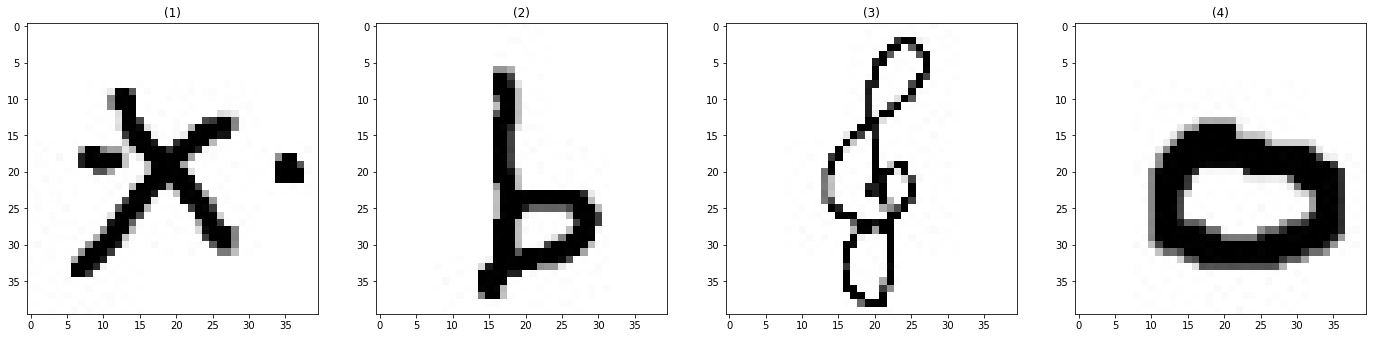

In [13]:
# Example
test_img_path = r'test.jpg'
test_img_path1 = r'test2.jpg'
test_img_path2 = r'test3.jpg'
test_img_path3 = r'test4.jpg'
img = cv2.imread(test_img_path)
img1 = cv2.imread(test_img_path1)
img2 = cv2.imread(test_img_path2)
img3 = cv2.imread(test_img_path3)
show_images([img,img1,img2,img3])
features = extract_features(img, 'hog')  # be careful of the choice of featu(re set
features1 = extract_features(img1, 'hog')  # be careful of the choice of featu(re set
features2 = extract_features(img2, 'hog')  # be careful of the choice of featu(re set
features3 = extract_features(img3, 'hog')  # be careful of the choice of featu(re set

In [15]:
nn = classifiers['SVM']
print(nn.predict([features]))
print(nn.predict([features1]))
print(nn.predict([features2]))
print(nn.predict([features3]))

['## ']
['&']
['[']
['a(1']


Try to get a better accuracy by changing the model hyperparameters and retraining.

Well done! You have now finished the Image Processing & Computer Vision course. Study well for the final exam 😄. If you have any questions, don't hesitate to ask now.